# **트레이딩 전략과 구현 6장 포트폴리오 이론**
**[파이썬 증권 데이터 분석 6장 | nbviewer](https://nbviewer.jupyter.org/github/INVESTAR/StockAnalysisInPython/tree/master/06_Trading_Strategy/)**
- **변동성 돌파, 추세추종, 반전** 3가지 매매기법 존재
- **추세추종, 반전 매매기법** 2가지를 확인해 본다

# **1 추세추종 매매기법 (볼린저 밴드 매매기법1)**
볼린저 밴드 이외에, **<span style="color:orange">현금흐름지표(MFI : Money Flow Index)</span>, 일중강도(II)** 와 같은 거래량 지표를 함께 확인한다
- 매수 : %b > **<span style="color:red">0.8</span>**, MFI > **<span style="color:red">80</span>** (상단밴드 접근, 지표 강세일 떄)
- 매도 : %b < **<span style="color:skyblue">0.2</span>**, MFI < **<span style="color:skyblue">20</span>** (하단밴드 접근, 지표 약세 확증시)

## **01 데이터 불러오기 + 볼린저 밴드 추가**
loading the Naver Stock Price Table

In [1]:
import os
import pandas as pd
file_save = "stock/boillingerNaver.csv"
if os.path.isfile(file_save):
    data_df = pd.read_csv(file_save)
    data_df['Date'] = pd.to_datetime(data_df['Date']) # datetime 포맷 변경
    data_df = data_df.set_index('Date')
else:
    from FinanceDataReader import DataReader as fdr
    data_df = fdr("035420", "2019-01-01")
    data_df.to_csv(file_save)

data_df.columns = [_.lower() for _ in data_df.columns]
data_raw = data_df.copy()
data_df.tail(3)

,open,high,low,close,volume,change
Date,,,,,,
2021-05-04,366000,367000,360500,364500,398383,0.004132
2021-05-06,360500,364500,359500,361500,632873,-0.008230
2021-05-07,360500,364000,360000,361000,444578,-0.001383


In [2]:
# 볼린저 밴드 데이터 추가
data_df['MA20'] = data_df['close'].rolling(window=20).mean() 
data_df['stddev'] = data_df['close'].rolling(window=20).std() 
data_df['upper'] = data_df['MA20'] + (data_df['stddev'] * 2)
data_df['lower'] = data_df['MA20'] - (data_df['stddev'] * 2)
data_df.tail(3)

,open,high,low,close,volume,change,MA20,stddev,upper,lower
Date,,,,,,,,,,
2021-05-04,366000,367000,360500,364500,398383,0.004132,380100.0,10074.198414,400248.396828,359951.603172
2021-05-06,360500,364500,359500,361500,632873,-0.008230,378950.0,10829.904991,400609.809981,357290.190019
2021-05-07,360500,364000,360000,361000,444578,-0.001383,377925.0,11523.745508,400972.491015,354877.508985


## **02 현금흐름지표 현금흐름지표(MFI : Money Flow Index)**
**중심 가격 (Typical Price)** 은 **<span style="color:orange">트레이딩이 집중적 발생하는 주가지점</span>** 을 확인하는 지표로써 **<span style="color:orange">일정기간의 고가, 저가, 종가</span>** 의 3평균으로 확인 가능하다

$$ MFI = 100 - (100 / (1+{(긍정적 현금 흐름) \over (부정적 현금 흐름)})) $$
 
- 긍정적 현금 흐름 PMF (Positive Money Flow) : **<span style="color:orange">중심 가격 (Typical Price)</span>** 이 전일보다 **<span style="color:orange">상승</span>** 한 기간의 현금흐름 합
- 부정적 현금 흐름 NMF (Nagative Money Flow) : 중심 가격 (Typical Price) 이 전일보다 **<span style="color:orange">하락</span>** 한 날들의 현금흐름 합

In [3]:
# 중심가격 (Typical Price) 의 계산 : 일정기간 고가/ 저가/ 종가의 3평균
data_df['TP'] = (data_df['high'] + data_df['low'] + data_df['close']) / 3
# PMF (Positive Money Flow)
data_df['PMF'] = 0 
data_df['NMF'] = 0
# 현금흐름값 : i+1 일차 중심가격 X i+1 일차 거래량
for i in range(len(data_df.close)-1):
    # 익일 중심가격이 높아진 경우 : PMF 현금흐름값 저장, NMF 는 0 저장
    if data_df.TP.values[i] < data_df.TP.values[i+1]: 
        data_df.PMF.values[i+1] = data_df.TP.values[i+1] * data_df.volume.values[i+1]
        data_df.NMF.values[i+1] = 0
    # 익일 중심가격이 높아진 경우 : PMF 0 저장, NMF 는 현금흐름값 저장
    else:
        data_df.NMF.values[i+1] = data_df.TP.values[i+1] * data_df.volume.values[i+1]
        data_df.PMF.values[i+1] = 0        

In [4]:
# 현금흐름비율 (MFR : Money Flow raito)
# : 10일 간의 긍정적 현금흐름의 합을 10일간 부정적 현금흐름의 합으로 나는 결과
data_df['MFR'] = (data_df.PMF.rolling(window=10).sum() /
    data_df.NMF.rolling(window=10).sum())
# 10일 간의 현금흐름지표 계살결과 저장
data_df['MFI10'] = 100 - 100 / (1 + data_df['MFR'])
data_df = data_df[19:]
data_df.tail(3)

,open,high,low,close,volume,change,MA20,stddev,upper,lower,TP,PMF,NMF,MFR,MFI10
Date,,,,,,,,,,,,,,,
2021-05-04,366000,367000,360500,364500,398383,0.004132,380100.0,10074.198414,400248.396828,359951.603172,364000.000000,0,145011412000,0.183772,15.524266
2021-05-06,360500,364500,359500,361500,632873,-0.008230,378950.0,10829.904991,400609.809981,357290.190019,361833.333333,0,228994547166,0.193509,16.213422
2021-05-07,360500,364000,360000,361000,444578,-0.001383,377925.0,11523.745508,400972.491015,354877.508985,361666.666667,0,160789043333,0.192362,16.132887


## **03 Visualization**
결과값 시각화 작업

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading ... Visualization Modules
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.font_manager import fontManager as fm # 한글폰트 확인 및 추가
font_list_check  = ['D2Coding', 'NanumGothicCoding', 'NanumGothic']
for _ in font_list_check:
    font_counts = [f  for f in font_list_check if _ in [_.name for _ in fm.ttflist]]
    if len(font_counts) > 1: print(f"found : {_}"); plt.rc('font', family=_); break 

found : D2Coding


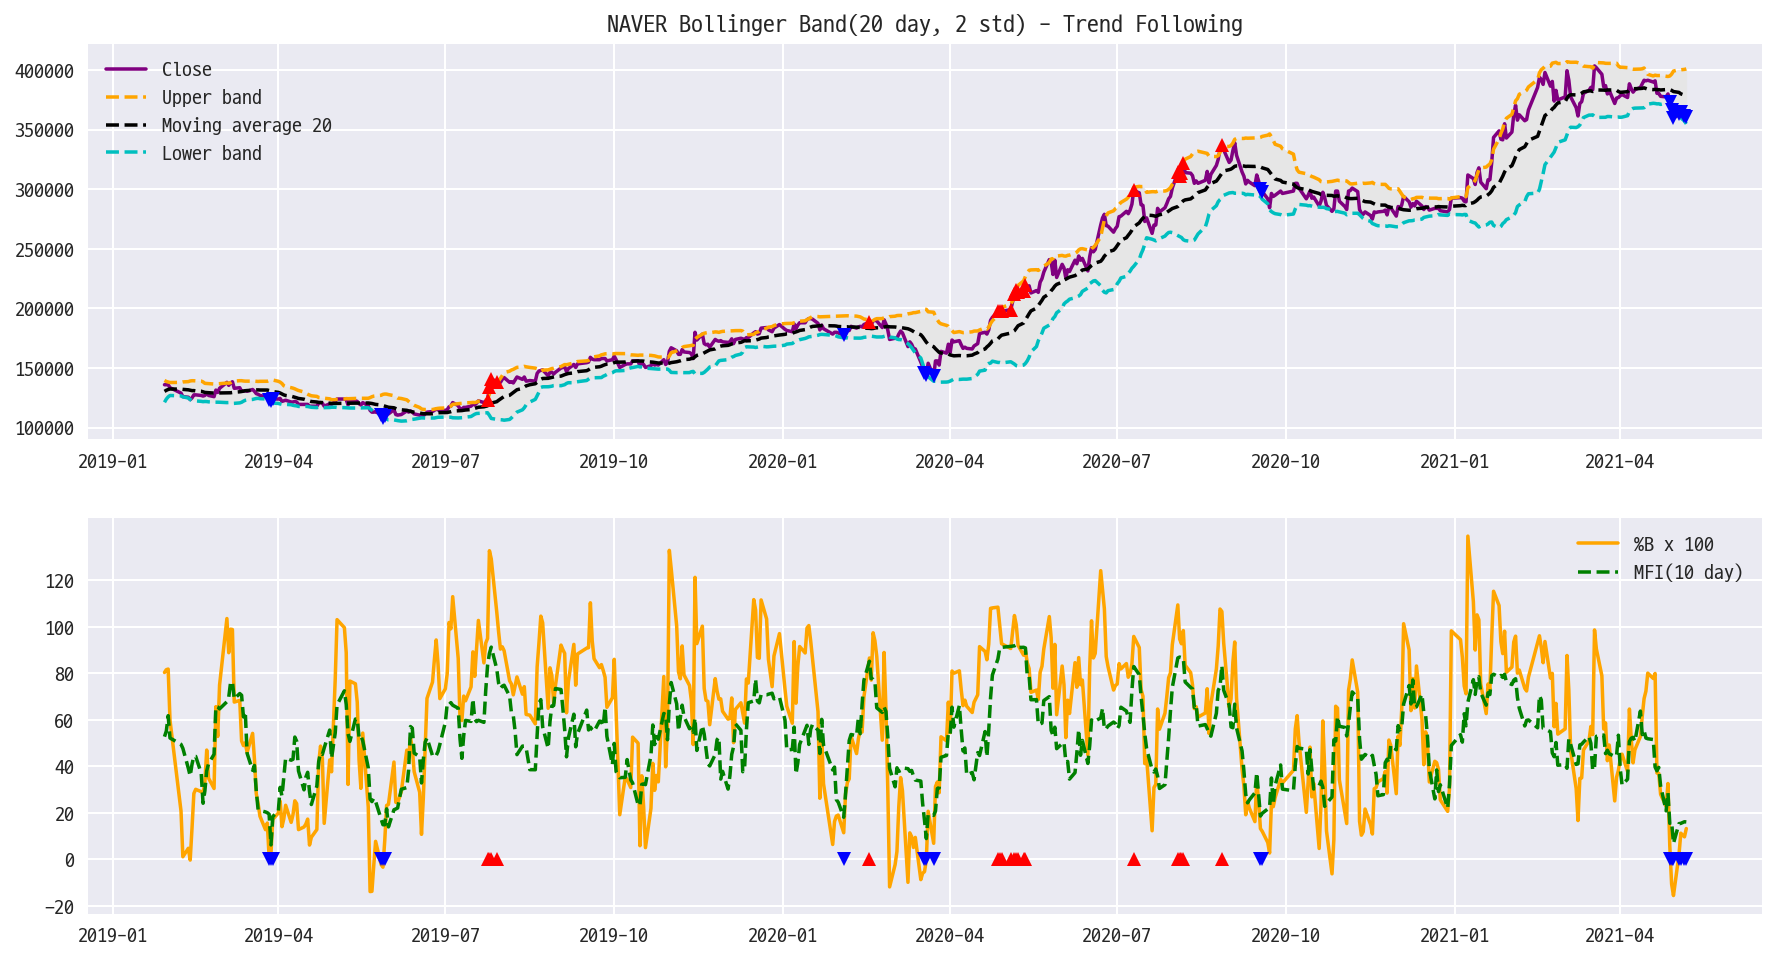

In [18]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.title('NAVER Bollinger Band(20 day, 2 std) - Trend Following')
plt.plot(data_df.index, data_df['close'], label='Close', color='purple')
plt.plot(data_df.index, data_df['upper'], '--', label ='Upper band', color='orange')
plt.plot(data_df.index, data_df['MA20'], 'k--', label='Moving average 20')
plt.plot(data_df.index, data_df['lower'], 'c--', label ='Lower band')
plt.fill_between(data_df.index, data_df['upper'], data_df['lower'], color='0.9')

data_df['PB'] = (data_df['close'] - data_df['lower']) / (data_df['upper'] - data_df['lower'])
for i in range(len(data_df.close)):
    if data_df.PB.values[i] > 0.8 and data_df.MFI10.values[i] > 80:
        plt.plot(data_df.index.values[i], data_df.close.values[i], 'r^')
    elif data_df.PB.values[i] < 0.2 and data_df.MFI10.values[i] < 20:
        plt.plot(data_df.index.values[i], data_df.close.values[i], 'bv')
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(data_df.index, data_df['PB'] * 100, label='%B x 100', color='orange') 
plt.plot(data_df.index, data_df['MFI10'], 'g--', label='MFI(10 day)')
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])
for i in range(len(data_df.close)):
    if data_df.PB.values[i] > 0.8 and data_df.MFI10.values[i] > 80:    # 매수시점
        plt.plot(data_df.index.values[i], 0, 'r^')
    elif data_df.PB.values[i] < 0.2 and data_df.MFI10.values[i] < 20:  # 매도시점
        plt.plot(data_df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show();   